In [1]:
#!source ../activate_conda.sh
import processor.FCNC_fake_rate_measurement as fr
import matplotlib.pyplot as plt
import awkward as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np
import pandas as pd
from yahist import Hist1D, Hist2D

# this is all very bad practice
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *
from Tools.nano_mapping import make_fileset, nano_mapping
from processor.meta_processor import get_sample_meta
from plots.helpers import makePlot, scale_and_merge

In [ ]:
from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output, dataset_axis, pt_axis, eta_axis

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset

overwrite  = True
flag_debug = False
debug_df_columns = ["pt","conePt","eta","dz","dxy","ptErrRel", "miniPFRelIso_all", "jetRelIsoV2", "jetRelIso", "jetPtRelv2", "event", "MET_PT", "mt", "num_tight_mu", "num_loose_mu"]
# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

year = 2018

samples = get_samples(f_in='samples_QCD.yaml')

fileset = make_fileset(['QCD'], samples, redirector=redirector_ucsd, small=True)
print(fileset)

add_processes_to_output(fileset, desired_output)
pt_axis_mu = hist.Bin("pt", r"$p_{T}$ (GeV)", [10., 15., 25.,  35., 50.])
eta_axis_mu =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.2, 2.1, 2.4])
pt_axis_e = hist.Bin("pt", r"$p_{T}$ (GeV)", [0, 25., 35., 45., 65., 100])
eta_axis_e =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.479, 2.5])

desired_output.update({
    "single_mu_fakeable": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_mu": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_e_fakeable": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_e": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "muons_df": processor.column_accumulator(np.zeros(shape=(0,len(debug_df_columns))))
})

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        fr.nano_analysis(year=year, variations=[], accumulator=desired_output, debug=flag_debug),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

#get weights and scale data
#meta = get_sample_meta(fileset, samples)
#my_hists = {}
#my_hists['single_mu_fakeable'] = scale_and_merge(output['single_mu_fakeable'], meta, fileset, nano_mapping)
#my_hists['single_mu'] = scale_and_merge(output['single_mu'], meta, fileset, nano_mapping)

{'/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM': ['root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/70000/DE335891-829A-B943-99BE-E5A179F5F3EB.root'], '/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/NANOAODSIM': ['root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/60000/01C056F5-F1AE-5048-AFFA-B601FF64B5E9.root'], '/QCD_Pt-15to20_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM': ['root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-15to20_MuEnrich

Preprocessing:   0%|          | 0/21 [00:00<?, ?file/s]

In [ ]:
fakeable_mu_hist = output["single_mu_fakeable"]
tight_mu_hist = output["single_mu"]

def make_yahist(x):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    return yahist_x

def divide_2D_hist(x, y):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    y_axis_0 = y.axes()[0].name
    y_axis_1 = y.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    yahist_y = Hist2D.from_bincounts(y.values()[()].T, (y.axis(y_axis_0).edges(), y.axis(y_axis_1).edges()))
    return yahist_x.divide(yahist_y)

make_yahist(tight_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy')

In [ ]:
#plot tight and loose counts for muons
fig, ax = plt.subplots(3, 1, figsize = (6,15))

make_yahist(tight_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0].set_title('Muon Tight Counts')


make_yahist(fakeable_mu_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Muon Loose Counts')

num_mu = tight_mu_hist.sum('dataset')
denom_mu = (fakeable_mu_hist).sum('dataset')
divide_2D_hist(num_mu, denom_mu).plot(show_counts=True, equidistant='xy', ax=ax[2])
ax[2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[2].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[2].set_title('Muon Fake Rate')

plt.savefig("/home/users/cmcmahon/public_html/fake_rates/fr_muon.pdf")
plt.show()

In [ ]:
fakeable_e_hist = output["single_e_fakeable"]
tight_e_hist = output["single_e"]

#plot tight and loose counts for muons
fig, ax = plt.subplots(3, 1, figsize = (6,15))

make_yahist(tight_e_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[0])
ax[0].set_xlabel(r'Cone $p_T$ (GeV)')
ax[0].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[0].set_title('Electron Tight Counts')


make_yahist(fakeable_e_hist.sum("dataset")).plot(show_counts=True, equidistant='xy', ax=ax[1])
ax[1].set_xlabel(r'Cone $p_T$ (GeV)')
ax[1].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[1].set_title('Electron Loose Counts')

num_e = tight_e_hist.sum('dataset')
denom_e = (fakeable_e_hist).sum('dataset')
divide_2D_hist(num_e, denom_e).plot(show_counts=True, equidistant='xy', ax=ax[2])
ax[2].set_xlabel(r'Cone $p_T$ (GeV)')
ax[2].set_ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
ax[2].set_title('Electron Fake Rate')

plt.savefig("/home/users/cmcmahon/public_html/fake_rates/fr_electron.pdf")
plt.show()

In [9]:
import pickle
FR_muon = divide_2D_hist(num_mu, denom_mu)
FR_electron = divide_2D_hist(num_e, denom_e)
pickle.dump(FR_muon, open("../data/fake_rate/FR_muon.p". "w"))
pickle.dump(FR_electron, open("../data/fake_rate/FR_electron.p". "w"))

Exception: Can't multiply histogram by non-scalar

In [ ]:
if flag_debug:
    events_p = pd.DataFrame(data=output["muons_df"].value, columns=debug_df_columns)
    bin_reqs_all = (events_p["MET_PT"] < 20)# & (events_p["mt"] < 20) & (events_p["conePt"] < 100)
    bin_reqs = [bin_reqs_all & (events_p["conePt"] > 10) & (events_p["conePt"] < 15) & ( events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
                bin_reqs_all & (events_p["conePt"] > 15) & (events_p["conePt"] < 25) & ( events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
                bin_reqs_all & (events_p["conePt"] > 25) & (events_p["conePt"] < 35) & ( events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
                bin_reqs_all & (events_p["conePt"] > 35) & (events_p["conePt"] < 50) & ( events_p["eta"] > -1.2) & (events_p["eta"] < 1.2),
                bin_reqs_all & (events_p["conePt"] > 10) & (events_p["conePt"] < 15) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
                bin_reqs_all & (events_p["conePt"] > 15) & (events_p["conePt"] < 25) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
                bin_reqs_all & (events_p["conePt"] > 25) & (events_p["conePt"] < 35) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
                bin_reqs_all & (events_p["conePt"] > 35) & (events_p["conePt"] < 50) & (((events_p["eta"] > 1.2) & (events_p["eta"] < 2.1)) | ((events_p["eta"] > -2.1) & (events_p["eta"] < -1.2))),
                bin_reqs_all & (events_p["conePt"] > 10) & (events_p["conePt"] < 15) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1))),
                bin_reqs_all & (events_p["conePt"] > 15) & (events_p["conePt"] < 25) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1))),
                bin_reqs_all & (events_p["conePt"] > 25) & (events_p["conePt"] < 35) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1))),
                bin_reqs_all & (events_p["conePt"] > 35) & (events_p["conePt"] < 50) & (((events_p["eta"] > 2.1) & (events_p["eta"] < 2.4)) | ((events_p["eta"] > -2.4) & (events_p["eta"] < -2.1)))]

    bin_names = ["(1,1)","(1,2)","(1,3)","(1,4)","(2,1)","(2,2)","(2,3)","(2,4)","(3,1)","(3,2)","(3,3)","(3,4)"]
    events_p.loc[events_p["event"]==6886009]

In [ ]:
events_p[bin_reqs[5]]

In [ ]:
if flag_debug:
    #output pandas df to csv files based on bins
    bin_test = events_p[bin_reqs_all]
    bin_test.to_csv("/home/users/cmcmahon/public_html/fake_rates/csv/all.csv")
    for b in range(len(bin_reqs)):
        tmp = events_p[bin_reqs[b]]
        tmp.to_csv("/home/users/cmcmahon/public_html/fake_rates/csv/bin_{}.csv".format(bin_names[b]))

In [ ]:
events = NanoEventsFactory.from_root('root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/70000/DE335891-829A-B943-99BE-E5A179F5F3EB.root', schemaclass=NanoAODSchema).events()

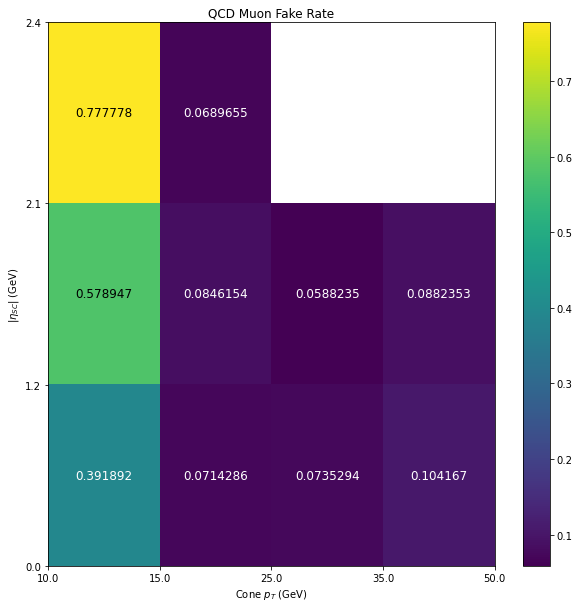

In [9]:
plt.figure("QCD_mu_fake_rate", figsize = (10,10))
divide_2D_hist(num_mu, denom_mu).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
plt.title('QCD Muon Fake Rate')
plt.show()

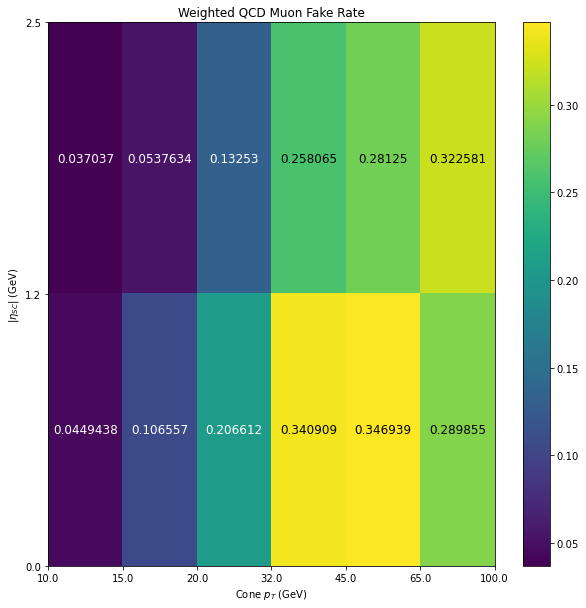

In [35]:
plt.figure("QCD_mu_fake_rate_weighted", figsize = (10,10))
divide_2D_hist(num_mu_weighted, denom_mu_weighted).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
plt.title('Weighted QCD Muon Fake Rate')
plt.show()

In [6]:
# pt_bins = hist.Bin("pt", r'$P_{T}\ GeV$', [0, 25., 35., 45., 65., 120.])#[[0, 25.],[25., 35.], [35., 45.], [45., 65.], [65., 120.]])
# eta_bins_mu = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.2, 1.2,  2.5])
# eta_bins_e = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.5, 1.5, 2.5])
rebinned_fakeable_mu_hist = fakeable_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_fakeable_e_hist = fakeable_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

rebinned_tight_mu_hist = tight_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_tight_e_hist = tight_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)

In [ ]:
# import uproot
# tree = uproot.open('root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/120000/DBBFA116-54FD-1F49-99EA-A95187A4D14C.root')['Events']
# tree.arrays(['MET_pt'])